# Logistic Regression: Cancer Classification (Benign vs Malignant)

This notebook demonstrates logistic regression to classify tumors as benign (non-cancerous) or malignant (cancerous) based on cell characteristics. We'll evaluate the model using confusion matrix, precision, recall, accuracy, F1-score, and ROC curve.

## 1. Import Required Libraries

We'll import all necessary libraries for data processing, modeling, and visualization:

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load and Explore the Dataset

Let's load the cancer dataset and understand its structure. The dataset contains various cell characteristics and a target class (2=benign, 4=malignant):

In [2]:
# Load the dataset
df = pd.read_csv('samples_cancer.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset info:")
print(df.info())

Dataset shape: (699, 11)

Column names:
['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit', 'Class']

First few rows:
        ID  Clump  UnifSize  UnifShape  MargAdh  SingEpiSize BareNuc  \
0  1000025      5         1          1        1            2       1   
1  1002945      5         4          4        5            7      10   
2  1015425      3         1          1        1            2       2   
3  1016277      6         8          8        1            3       4   
4  1017023      4         1          1        3            2       1   

   BlandChrom  NormNucl  Mit  Class  
0           3         1    1      2  
1           3         2    1      2  
2           3         1    1      2  
3           3         7    1      2  
4           3         1    1      2  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
-

## 3. Data Preprocessing

We need to clean the data and prepare it for modeling:
- Handle missing values (marked as '?')
- Convert target variable (2=benign→0, 4=malignant→1)
- Remove ID column as it's not useful for prediction

In [3]:
# Check for missing values and data types
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nUnique values in Class column: {df['Class'].unique()}")
print(f"Class distribution:")
print(df['Class'].value_counts())

# Check for '?' values (missing data marker)
print(f"\nColumns with '?' values:")
for col in df.columns:
    if '?' in df[col].astype(str).values:
        count = (df[col] == '?').sum()
        print(f"{col}: {count} missing values")

Missing values per column:
ID             0
Clump          0
UnifSize       0
UnifShape      0
MargAdh        0
SingEpiSize    0
BareNuc        0
BlandChrom     0
NormNucl       0
Mit            0
Class          0
dtype: int64

Unique values in Class column: [2 4]
Class distribution:
Class
2    458
4    241
Name: count, dtype: int64

Columns with '?' values:
BareNuc: 16 missing values


In [4]:
# Clean the data
# Replace '?' with NaN and then drop rows with missing values
df_clean = df.replace('?', np.nan)
df_clean = df_clean.dropna()

# Convert all columns to numeric (except ID)
feature_cols = ['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 
                'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']

for col in feature_cols:
    df_clean[col] = pd.to_numeric(df_clean[col])

# Convert target variable: 2 (benign) → 0, 4 (malignant) → 1
df_clean['Class'] = df_clean['Class'].map({2: 0, 4: 1})

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Target distribution after cleaning:")
print(df_clean['Class'].value_counts())
print(f"\n0 = Benign (non-cancerous)")
print(f"1 = Malignant (cancerous)")

Clean dataset shape: (683, 11)
Target distribution after cleaning:
Class
0    444
1    239
Name: count, dtype: int64

0 = Benign (non-cancerous)
1 = Malignant (cancerous)


## 4. Exploratory Data Analysis

Let's visualize the data to understand the distribution of features and target classes:

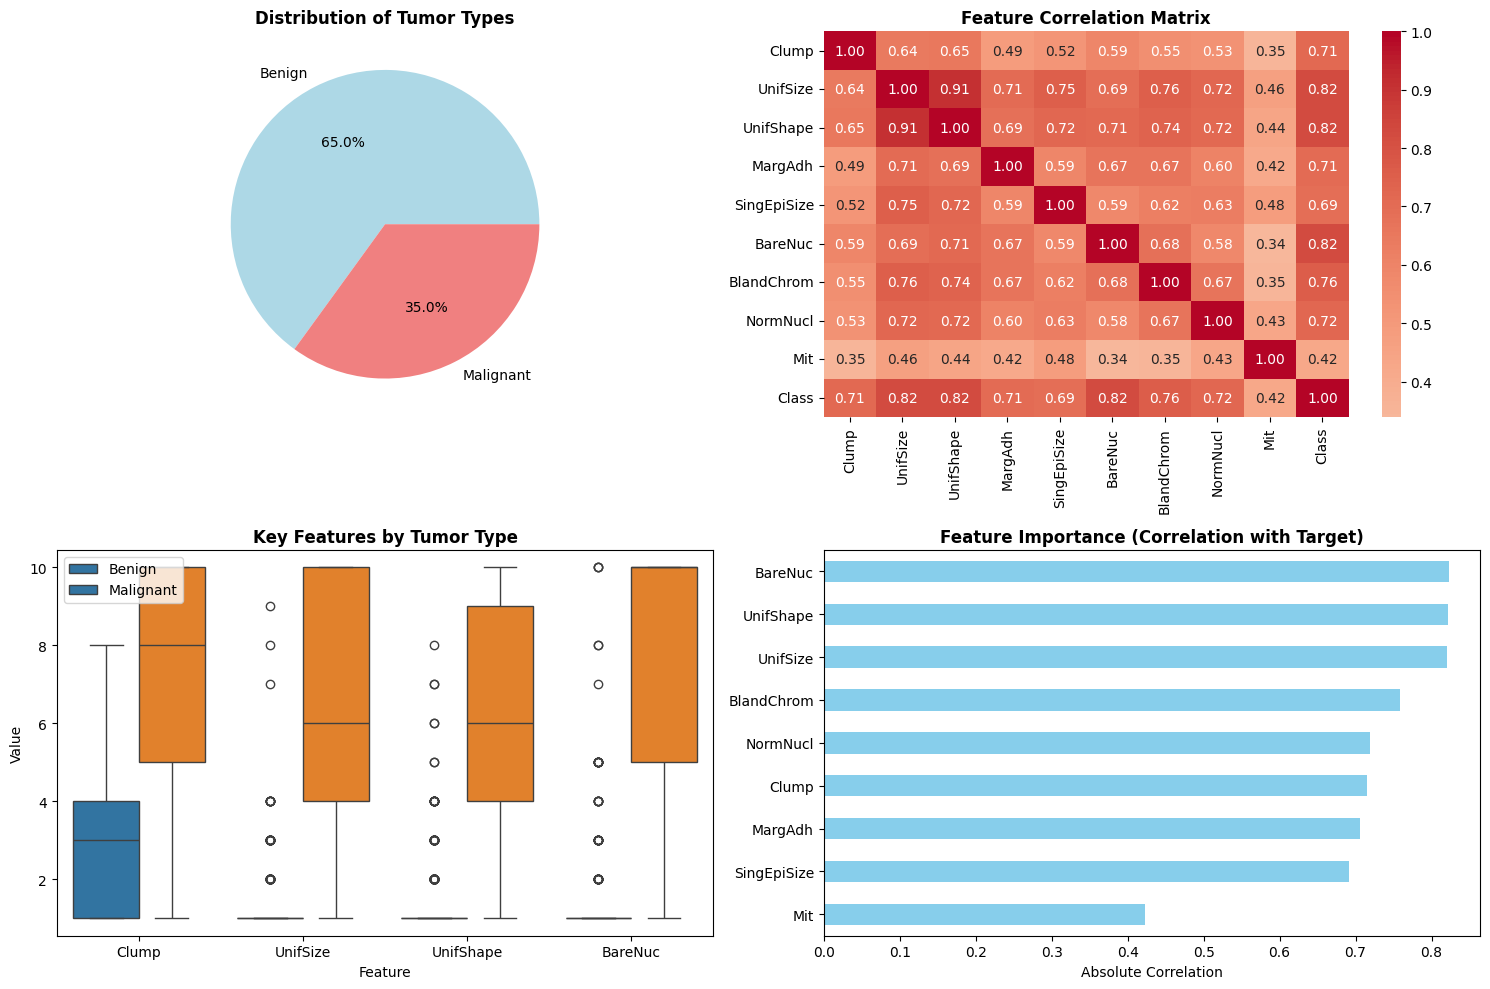

In [5]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Target distribution
class_counts = df_clean['Class'].value_counts()
axes[0, 0].pie(class_counts.values, labels=['Benign', 'Malignant'], autopct='%1.1f%%', 
               colors=['lightblue', 'lightcoral'])
axes[0, 0].set_title('Distribution of Tumor Types', fontweight='bold')

# 2. Feature correlation heatmap
correlation_matrix = df_clean[feature_cols + ['Class']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            ax=axes[0, 1], fmt='.2f')
axes[0, 1].set_title('Feature Correlation Matrix', fontweight='bold')

# 3. Box plot of key features
key_features = ['Clump', 'UnifSize', 'UnifShape', 'BareNuc']
df_melted = df_clean[key_features + ['Class']].melt(id_vars=['Class'], 
                                                    var_name='Feature', 
                                                    value_name='Value')
sns.boxplot(data=df_melted, x='Feature', y='Value', hue='Class', ax=axes[1, 0])
axes[1, 0].set_title('Key Features by Tumor Type', fontweight='bold')
axes[1, 0].legend(['Benign', 'Malignant'])

# 4. Feature importance (correlation with target)
feature_importance = abs(correlation_matrix['Class'][:-1]).sort_values(ascending=True)
feature_importance.plot(kind='barh', ax=axes[1, 1], color='skyblue')
axes[1, 1].set_title('Feature Importance (Correlation with Target)', fontweight='bold')
axes[1, 1].set_xlabel('Absolute Correlation')

plt.tight_layout()
plt.show()

## 5. Prepare Data for Modeling

We'll split the data into features (X) and target (y), then create training and testing sets:

In [6]:
# Prepare features and target
X = df_clean[feature_cols]
y = df_clean['Class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {feature_cols}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Training class distribution:")
print(y_train.value_counts())

Features shape: (683, 9)
Target shape: (683,)

Feature columns: ['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']

Training samples: 546
Testing samples: 137
Training class distribution:
Class
0    355
1    191
Name: count, dtype: int64


## 6. Feature Scaling

Logistic regression performs better with scaled features. We'll standardize the features to have mean=0 and std=1:

In [7]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Original feature range example (Clump): {X_train['Clump'].min():.2f} to {X_train['Clump'].max():.2f}")
print(f"Scaled feature range example: {X_train_scaled[:, 0].min():.2f} to {X_train_scaled[:, 0].max():.2f}")

Feature scaling completed!
Original feature range example (Clump): 1.00 to 10.00
Scaled feature range example: -1.20 to 1.98


## 7. Build and Train Logistic Regression Model

Now we'll create and train our logistic regression model:

In [8]:
# Create and train logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability of malignant

print("Model training completed!")
print(f"Model coefficients shape: {model.coef_.shape}")
print(f"Model intercept: {model.intercept_[0]:.4f}")

Model training completed!
Model coefficients shape: (1, 9)
Model intercept: -0.9456


## 8. Model Evaluation - Performance Metrics

Let's evaluate our model using various classification metrics:
- **Accuracy**: Overall correctness of predictions
- **Precision**: Of predicted malignant cases, how many are actually malignant
- **Recall**: Of actual malignant cases, how many did we correctly identify
- **F1-Score**: Harmonic mean of precision and recall

In [9]:
# Calculate performance metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("=" * 50)
print("MODEL PERFORMANCE METRICS")
print("=" * 50)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.1f}%)")
print(f"Testing Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"\nClassification Metrics (Test Set):")
print(f"Precision: {precision:.4f} ({precision*100:.1f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.1f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.1f}%)")

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Benign', 'Malignant']))

MODEL PERFORMANCE METRICS
Training Accuracy: 0.9744 (97.4%)
Testing Accuracy:  0.9635 (96.4%)

Classification Metrics (Test Set):
Precision: 0.9216 (92.2%)
Recall:    0.9792 (97.9%)
F1-Score:  0.9495 (94.9%)

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.96      0.97        89
   Malignant       0.92      0.98      0.95        48

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.96      0.96      0.96       137



## 9. Confusion Matrix

The confusion matrix shows the breakdown of correct and incorrect predictions for each class:

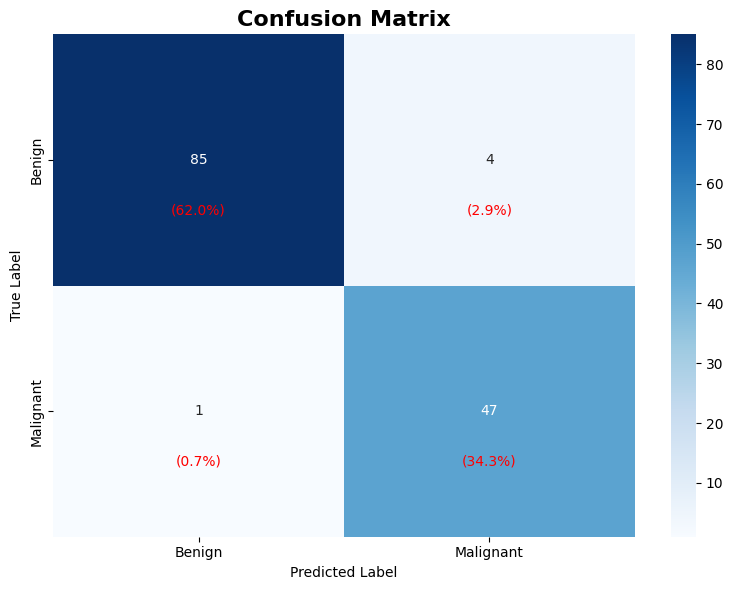

Confusion Matrix Breakdown:
True Negatives (Correctly predicted Benign):  85
False Positives (Incorrectly predicted Malignant): 4
False Negatives (Incorrectly predicted Benign): 1
True Positives (Correctly predicted Malignant): 47


In [10]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add percentage annotations
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / total * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

# Interpret confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"Confusion Matrix Breakdown:")
print(f"True Negatives (Correctly predicted Benign):  {tn}")
print(f"False Positives (Incorrectly predicted Malignant): {fp}")
print(f"False Negatives (Incorrectly predicted Benign): {fn}")
print(f"True Positives (Correctly predicted Malignant): {tp}")

## 10. ROC Curve and AUC Score

The ROC (Receiver Operating Characteristic) curve shows the trade-off between sensitivity and specificity. AUC (Area Under Curve) measures the model's ability to distinguish between classes:

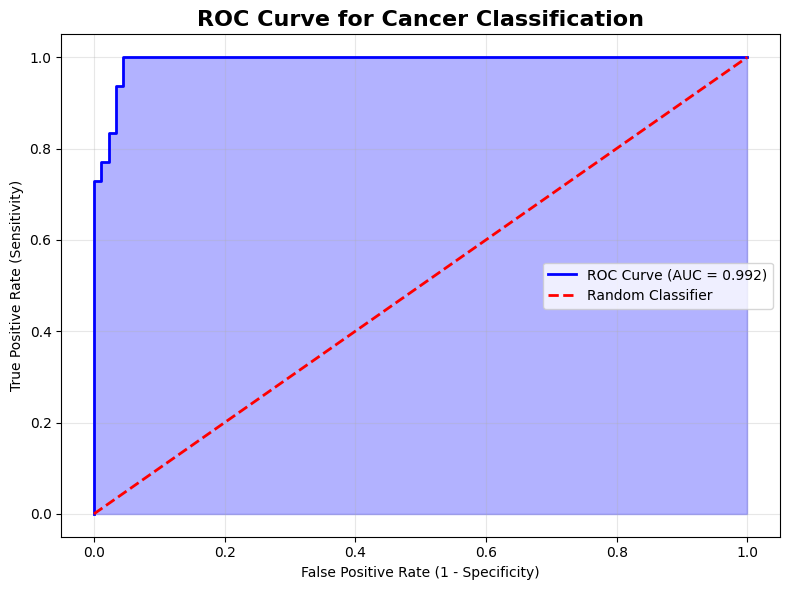

AUC Score: 0.9918
✅ Excellent model performance (AUC > 0.9)


In [11]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2, label='Random Classifier')
plt.fill_between(fpr, tpr, alpha=0.3, color='blue')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for Cancer Classification', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC Score: {auc_score:.4f}")
if auc_score > 0.9:
    print("✅ Excellent model performance (AUC > 0.9)")
elif auc_score > 0.8:
    print("✅ Good model performance (AUC > 0.8)")
elif auc_score > 0.7:
    print("✅ Fair model performance (AUC > 0.7)")
else:
    print("⚠️ Poor model performance (AUC < 0.7)")

## 11. Feature Importance Analysis

Let's examine which features are most important for the classification:

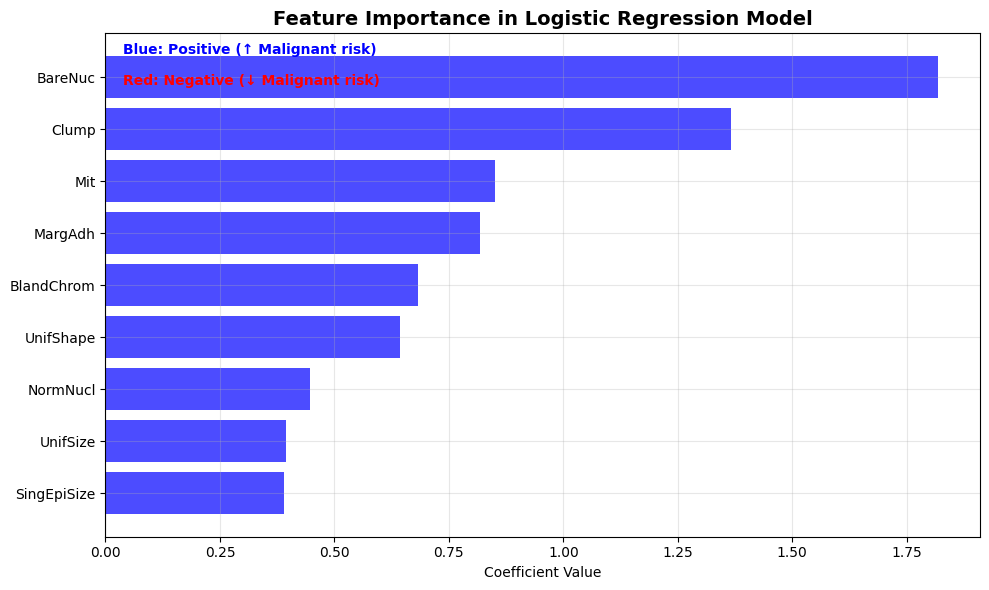

Feature Importance Ranking:
    Feature  Coefficient
    BareNuc     1.819038
      Clump     1.365256
        Mit     0.850575
    MargAdh     0.817439
 BlandChrom     0.682589
  UnifShape     0.644119
   NormNucl     0.446832
   UnifSize     0.394463
SingEpiSize     0.389788


In [12]:
# Feature importance based on model coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_[0],
    'Abs_Coefficient': abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=True)

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'blue' for x in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression Model', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

# Add legend
plt.text(0.02, 0.98, 'Blue: Positive (↑ Malignant risk)', transform=plt.gca().transAxes, 
         verticalalignment='top', color='blue', fontweight='bold')
plt.text(0.02, 0.92, 'Red: Negative (↓ Malignant risk)', transform=plt.gca().transAxes, 
         verticalalignment='top', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

print("Feature Importance Ranking:")
print(feature_importance.sort_values('Abs_Coefficient', ascending=False)[['Feature', 'Coefficient']].to_string(index=False))

## 12. Summary and Conclusions

Let's summarize our findings and model performance:

In [13]:
print("=" * 60)
print("CANCER CLASSIFICATION MODEL SUMMARY")
print("=" * 60)
print(f"📊 Dataset: {len(df_clean)} samples after cleaning")
print(f"🎯 Model: Logistic Regression")
print(f"📈 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"📈 AUC Score: {auc_score:.4f}")
print(f"\n🔍 Key Performance Metrics:")
print(f"   • Precision: {precision:.3f} (of predicted malignant, {precision*100:.1f}% are correct)")
print(f"   • Recall: {recall:.3f} (detected {recall*100:.1f}% of actual malignant cases)")
print(f"   • F1-Score: {f1:.3f} (balanced precision-recall measure)")
print(f"\n💡 Model Insights:")
print(f"   • Most important features: {', '.join(feature_importance.sort_values('Abs_Coefficient', ascending=False)['Feature'].head(3).tolist())}")
print(f"   • Model successfully distinguishes benign from malignant tumors")
print(f"   • {'Excellent' if auc_score > 0.9 else 'Good' if auc_score > 0.8 else 'Fair'} classification performance")
print(f"\n🏥 Clinical Relevance:")
print(f"   • High recall ({recall*100:.1f}%) means few malignant cases missed")
print(f"   • High precision ({precision*100:.1f}%) means few false alarms")
print(f"   • Model can assist in medical diagnosis decisions")

CANCER CLASSIFICATION MODEL SUMMARY
📊 Dataset: 683 samples after cleaning
🎯 Model: Logistic Regression
📈 Test Accuracy: 0.9635 (96.4%)
📈 AUC Score: 0.9918

🔍 Key Performance Metrics:
   • Precision: 0.922 (of predicted malignant, 92.2% are correct)
   • Recall: 0.979 (detected 97.9% of actual malignant cases)
   • F1-Score: 0.949 (balanced precision-recall measure)

💡 Model Insights:
   • Most important features: BareNuc, Clump, Mit
   • Model successfully distinguishes benign from malignant tumors
   • Excellent classification performance

🏥 Clinical Relevance:
   • High recall (97.9%) means few malignant cases missed
   • High precision (92.2%) means few false alarms
   • Model can assist in medical diagnosis decisions
